# Task3

## Import data

In [65]:
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

batch_size = 32 # number of images in each batch
img_size = (32, 32) # 32 x 32 pixel images in input data

uri = r'C:\Users\markus\.keras\datasets\CIFAR-10-images'

train_dataset, validation_dataset = keras.utils.image_dataset_from_directory(
    uri + r'\train',
    batch_size=batch_size, 
    image_size=img_size,
    label_mode='categorical',
    validation_split=0.2, 
    subset='both',
    seed=123)

test_dataset = keras.utils.image_dataset_from_directory(
    uri + r'\test',
    batch_size=batch_size, 
    image_size=img_size,
    label_mode='categorical')

# Print dataset shape

Found 50000 files belonging to 10 classes.
Using 40000 files for training.
Using 10000 files for validation.
Found 10000 files belonging to 10 classes.


# Creating the model

I will use a pretrained model for the convolution base and then train our own classifier on top of it.

I will try few different models and see which one performs the best.

Models tried:
1. VGG16
2. VGG19
3. ResNet50

In [66]:
from keras import Sequential
from keras import layers

# Import all apps

import keras.applications as kapps

# Select model to use as convolution_base
model_selection = 2

# 1. VGG16
# 2. VGG19
# 3. ResNet50

# Set params based on selection

if model_selection == 1:
    conv_base = kapps.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    preprocess_func = kapps.vgg16.preprocess_input
elif model_selection == 2:
    conv_base = kapps.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    preprocess_func = kapps.vgg19.preprocess_input
elif model_selection == 3:
    conv_base = kapps.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    preprocess_func = kapps.resnet.preprocess_input
else:
    raise ValueError("Invalid model selection. Choose between 1 (VGG16), 2 (VGG19), or 3 (Xception).")

conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

## Feature extraction

I will use the convolutional base of the model to extract features from the images. I will then use these features to train a classifier.

I will use fast feature extraction to extract features from the images.

In [67]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    
    for images, labels in dataset:
        preprocessed_images = preprocess_func(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
        
    return np.concatenate(all_features), np.concatenate(all_labels)


# Get features and labes for all datasets

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

# Print the shape of the extraction

train_features.shape

1/1 [==============================] - 0s 28ms/step


(40000, 1, 1, 512)

## Create classifier on top of the convolutional base

I will create a classifier on top of the convolutional base and train it on the extracted features to create the final model.

I will use 2 dense layers with dropout to create the classifier.

In [ ]:

model = Sequential([
    layers.Input(shape=(1, 1, 512)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu"),
    layers.Dense(250, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(100, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2), 
    layers.Dense(10, activation="softmax")
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_30 (Flatten)        (None, 512)               0         
                                                                 
 dropout_46 (Dropout)        (None, 512)               0         
                                                                 
 dense_94 (Dense)            (None, 512)               262656    
                                                                 
 dense_95 (Dense)            (None, 250)               128250    
                                                                 
 dropout_47 (Dropout)        (None, 250)               0         
                                                                 
 dense_96 (Dense)            (None, 100)               25100     
                                                                 
 batch_normalization_9 (Batc  (None, 100)            

In [ ]:
callbacks=[
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_features, train_labels, 
    validation_data=(val_features, val_labels),   
    epochs=30,
    callbacks=callbacks, 
    verbose=1)

Epoch 1/20
1250/1250 [==============================] - 7s 5ms/step - loss: 1.5635 - accuracy: 0.4554 - val_loss: 1.1858 - val_accuracy: 0.5855
Epoch 2/20
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3449 - accuracy: 0.5300 - val_loss: 1.1392 - val_accuracy: 0.6095
Epoch 3/20
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2922 - accuracy: 0.5512 - val_loss: 1.1277 - val_accuracy: 0.6202
Epoch 4/20
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2606 - accuracy: 0.5602 - val_loss: 1.1378 - val_accuracy: 0.6176
Epoch 5/20
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2312 - accuracy: 0.5736 - val_loss: 1.0943 - val_accuracy: 0.6299
Epoch 6/20
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2058 - accuracy: 0.5799 - val_loss: 1.0872 - val_accuracy: 0.6291
Epoch 7/20
1250/1250 [==============================] - 6s 4ms/step - loss: 1.1854 - accuracy: 0.5879 - val_loss: 1.0820 - val_accuracy:

## Plot results

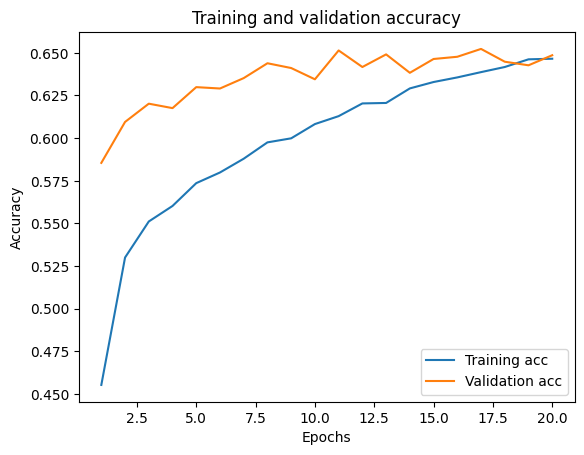

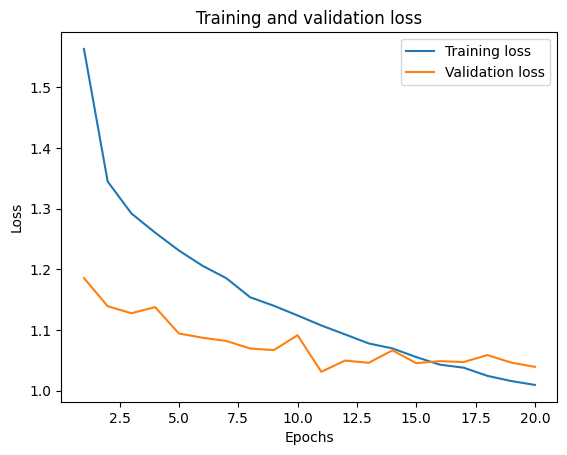

Training accuracy: 0.6465
Validation accuracy: 0.6486
Training loss: 1.0095
Validation loss: 1.0393


In [141]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()        
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

print(f"Training accuracy: {acc[-1]:.4f}")
print(f"Validation accuracy: {val_acc[-1]:.4f}")
print(f"Training loss: {loss[-1]:.4f}")
print(f"Validation loss: {val_loss[-1]:.4f}")

## Evaluate model

Finally, I will evaluate the model on the test data and see how well it performs.

In [102]:
# Get best saved checkpoint
test_model = keras.models.load_model("feature_extraction.keras")

test_loss, test_acc = test_model.evaluate(test_features, test_labels)

print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.1396 - accuracy: 0.6169
Test accuracy: 0.6169
Test loss: 1.1396
